# COMP8220 - Final Project
## Asim Adnan Eijaz - 45565694

# Introduction

This notebook is for the major project submission for COMP8220, on the image dataset and task. It contains the following sections:

*   Problem Statement
*   A description of the selected conventional ML model;
*   Description of each Deep learning model and choices made
*   Consulusion



# Problem Statement
For this problem, we are working with the CelebA dataset, a widely used dataset of celebrity faces. The task is to predict the hair colour of the celebrity, which will be one of black, brown, blond or gray.

All data is available in Kaggle at this [URL](https://www.kaggle.com/c/celeba-guess-hair/overview)

For testing, there'll be a public test set and a private test set.

# Accessing the Data
The following code is used for downloading data from kaggle into Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/CelebA/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'celeba-guess-hair' -p /content/gdrive/My\ Drive/CelebA
import os
os.getcwd()
os.chdir('/content/gdrive/My Drive/CelebA') 
! unzip test_public_images.npy.zip -d test_public_images
! unzip val_images.npy.zip -d val_images
! unzip train_images.npy.zip -d train_images
! unzip train_files.npy.zip -d train_files

Archive:  test_public_images.npy.zip
  inflating: test_public_images/test_public_images.npy  
Archive:  val_images.npy.zip
  inflating: val_images/val_images.npy  
Archive:  train_images.npy.zip
  inflating: train_images/train_images.npy  
Archive:  train_files.npy.zip
  inflating: train_files/train_files.npy  


In [0]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'hair-colour-prediction-private' -p /content/gdrive/My\ Drive/CelebA
import os



Saving kaggle.json to kaggle.json
 97% 73.0M/75.4M [00:04<00:00, 10.7MB/s]
100% 75.4M/75.4M [00:04<00:00, 16.0MB/s]
  0% 0.00/341k [00:00<?, ?B/s]
100% 341k/341k [00:00<00:00, 11.1MB/s]
  0% 0.00/113k [00:00<?, ?B/s]
100% 113k/113k [00:00<00:00, 16.1MB/s]


'/content'

In [0]:
! unzip test_private_images.npy.zip -d test_private_images
! unzip test_private_files.npy.zip -d test_private_files


Archive:  test_private_images.npy.zip
  inflating: test_private_images/test_private_images.npy  
Archive:  test_private_files.npy.zip
  inflating: test_private_files/test_private_files.npy  


In [0]:
!mv "/content/gdrive/My Drive/CelebA/test_public_images/test_public_images.npy" "/content/gdrive/My Drive/CelebA/"
!mv "/content/gdrive/My Drive/CelebA/val_images/val_images.npy" "/content/gdrive/My Drive/CelebA/"
!mv "/content/gdrive/My Drive/CelebA/train_images/train_images.npy" "/content/gdrive/My Drive/CelebA/"
!mv "/content/gdrive/My Drive/CelebA/train_files/train_files.npy" "/content/gdrive/My Drive/CelebA/"



mv: cannot stat '/content/gdrive/My Drive/CelebA/test_public_images/test_public_images.npy': No such file or directory
mv: cannot stat '/content/gdrive/My Drive/CelebA/val_images/val_images.npy': No such file or directory
mv: cannot stat '/content/gdrive/My Drive/CelebA/train_images/train_images.npy': No such file or directory
mv: cannot stat '/content/gdrive/My Drive/CelebA/train_files/train_files.npy': No such file or directory


Importing All important Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from google.colab import drive
from os.path import join

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.models import load_model
from scipy import stats
from random import seed 
from random import randint

seed(23)
%matplotlib inline


Using TensorFlow backend.


This code here extracts images, labels and filenames from .npy files and stores them in nupy arrays.

In [0]:
image_size = 48
hair_colours = ['black', 'blond', 'brown', 'gray']
dataset_directory = '/content/drive/My Drive/CelebA' 

images_train = np.load(join(dataset_directory, 'train_images.npy'))
labels_train = np.load(join(dataset_directory, 'train_labels.npy'))

images_val = np.load(join(dataset_directory, 'val_images.npy'))
labels_val = np.load(join(dataset_directory, 'val_labels.npy'))
files_val = np.load(join(dataset_directory, 'val_files.npy'))

images_test_public = np.load(join(dataset_directory, 'test_public_images.npy'))
files_test_public = np.load(join(dataset_directory, 'test_public_files.npy'))

images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0

train_labels = to_categorical(labels_train)
val_labels = to_categorical(labels_val)

print(images_train.shape)
print(images_val.shape)
print(images_test_public.shape)

(98479, 48, 48, 3)
(12270, 48, 48, 3)
(11921, 48, 48, 3)


In [0]:
images_test_private = np.load(join(dataset_directory, 'test_private_images.npy'))
files_test_private = np.load(join(dataset_directory, 'test_private_files.npy'))
images_test_private = images_test_private.reshape([-1, image_size, image_size, 3]) / 255.0

print(images_test_private.shape)

(13143, 48, 48, 3)


Even though we are given data already divided into Training and validation sets, the data was combined here to create a balanced validation set, to try to see if that improved the perfromance.

In [0]:
total_images = np.concatenate((images_train, images_val))
total_labels = np.concatenate((train_labels, val_labels))

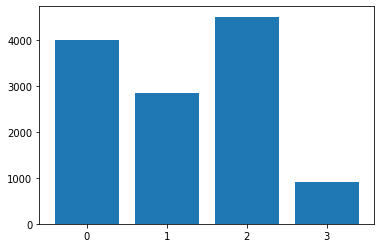

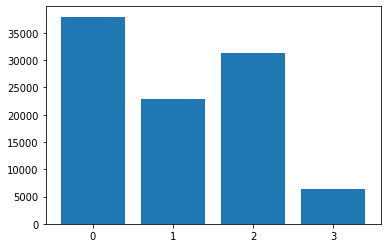

In [0]:
unique, counts = np.unique(labels_val, return_counts=True)
val = dict(zip(unique, counts))

unique, counts = np.unique(labels_train, return_counts=True)
train = dict(zip(unique, counts))

D = val
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

D = train
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

The Bar plots above show target class distribution in validation and test set, the distribution is similar in both sets, but as we can see class 3 has very few observations in train set, which may make prediction of that class less accurate in our final mode.

This function below was taken from [Stackoverflow](https://stackoverflow.com/a/47555856) to split data with equal number of each target class, to get a balanced trining and validation set. We'll find out later if this technique worked for us or not.

In [0]:
def split_balanced(data, target, test_size=0.2):

    classes = np.unique(target)
    # can give test_size as fraction of input data size of number of samples
    if test_size<1:
        n_test = np.round(len(target)*test_size)
    else:
        n_test = test_size
    n_train = max(0,len(target)-n_test)
    n_train_per_class = max(1,int(np.floor(n_train/len(classes))))
    n_test_per_class = max(1,int(np.floor(n_test/len(classes))))

    ixs = []
    for cl in classes:
        if (n_train_per_class+n_test_per_class) > np.sum(target==cl):
            # if data has too few samples for this class, do upsampling
            # split the data to training and testing before sampling so data points won't be
            #  shared among training and test data
            splitix = int(np.ceil(n_train_per_class/(n_train_per_class+n_test_per_class)*np.sum(target==cl)))
            ixs.append(np.r_[np.random.choice(np.nonzero(target==cl)[0][:splitix], n_train_per_class),
                np.random.choice(np.nonzero(target==cl)[0][splitix:], n_test_per_class)])
        else:
            ixs.append(np.random.choice(np.nonzero(target==cl)[0], n_train_per_class+n_test_per_class,
                replace=False))

    # take same num of samples from all classes
    ix_train = np.concatenate([x[:n_train_per_class] for x in ixs])
    ix_test = np.concatenate([x[n_train_per_class:(n_train_per_class+n_test_per_class)] for x in ixs])

    X_train = data[ix_train,:]
    X_test = data[ix_test,:]
    y_train = target[ix_train]
    y_test = target[ix_test]

    return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = split_balanced(total_images,
                                                    total_labels,
                                                    test_size=0.25)


This is our balanced division of data, and we'll train same models on 2 different division of our data we have to see which one perfroms better.

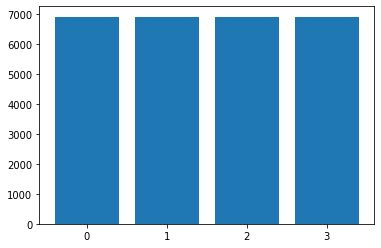

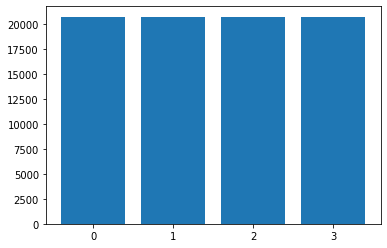

In [0]:
unique, counts = np.unique(y_test, return_counts=True)
val = dict(zip(unique, counts))

unique, counts = np.unique(y_train, return_counts=True)
train = dict(zip(unique, counts))
D = val

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()
D = train

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

From plots above it can bee seen that, our training and validation set now have equal number of classes for each target class.

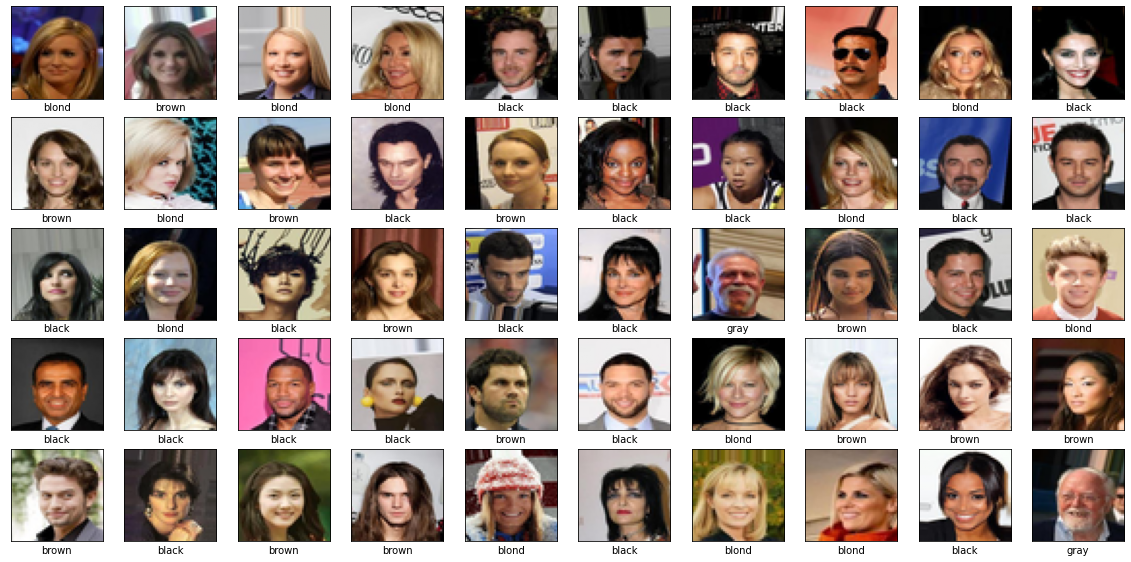

In [0]:
plt.figure(figsize=(20,20))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    num = randint(0,len(images_train))
    plt.imshow(images_train[num], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(hair_colours[labels_train[num]])
plt.show()

Above we have plotted some random images from our training data.

Some Helper Functions for our model building part

In [0]:
def plot_history(model,epoch):
  history = model.history
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epoch)

  plt.figure(figsize=(25, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


def download_results(model):
  pred_public = np.argmax(model.predict(images_test_public), axis=-1)
  df = pd.DataFrame(
    {'ID': files_test_public,
     'Prediction': pred_public
    })
  df[['Prediction']] = df[['Prediction']].astype(int)
  df.to_csv('RESULTS.csv', index=False)
  files.download("RESULTS.csv")

def val_accuracy(model,val_X,val_y):
  pred_val = np.argmax(model.predict(val_X), axis=-1)
  print('Validation Accuracy',accuracy_score(np.argmax(val_y, axis=1) , pred_val))



The first Conventional Machine Learning Model applied was a simple neural Network, with a Conv2d Layer, a MaxPooling Layer, and 2 Dense Layer. With total 4.7 Mil Trainable parameters.
The loss function used is binary_crosentropy, and optimizer is adam.

In [0]:
model_basic = Sequential()
model_basic.add(keras.layers.Conv2D(64, 7, activation="relu", padding="same",input_shape=[48, 48, 3]))
model_basic.add(keras.layers.MaxPooling2D(2))
model_basic.add(keras.layers.Flatten())
model_basic.add(keras.layers.Dense(128, activation="relu"))
model_basic.add(keras.layers.Dense(4, activation="softmax"))

model_basic.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 64)        9472      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4718720   
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
Total params: 4,728,708
Trainable params: 4,728,708
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_basic.fit(images_train, train_labels, epochs=10, validation_data=(images_val, val_labels), batch_size=128)

Train on 98479 samples, validate on 12270 samples
Epoch 1/10
98479/98479 [==============================] - 25s 256us/step - loss: 0.1592 - accuracy: 0.9366 - val_loss: 0.1752 - val_accuracy: 0.9289
Epoch 2/10
98479/98479 [==============================] - 25s 253us/step - loss: 0.1406 - accuracy: 0.9445 - val_loss: 0.1470 - val_accuracy: 0.9398
Epoch 3/10
98479/98479 [==============================] - 25s 253us/step - loss: 0.1253 - accuracy: 0.9507 - val_loss: 0.1714 - val_accuracy: 0.9315
Epoch 4/10
98479/98479 [==============================] - 25s 254us/step - loss: 0.1117 - accuracy: 0.9565 - val_loss: 0.1505 - val_accuracy: 0.9411
Epoch 5/10
98479/98479 [==============================] - 25s 255us/step - loss: 0.0975 - accuracy: 0.9625 - val_loss: 0.1611 - val_accuracy: 0.9380
Epoch 6/10
98479/98479 [==============================] - 25s 254us/step - loss: 0.0831 - accuracy: 0.9685 - val_loss: 0.1634 - val_accuracy: 0.9411
Epoch 7/10
98479/98479 [==============================] 

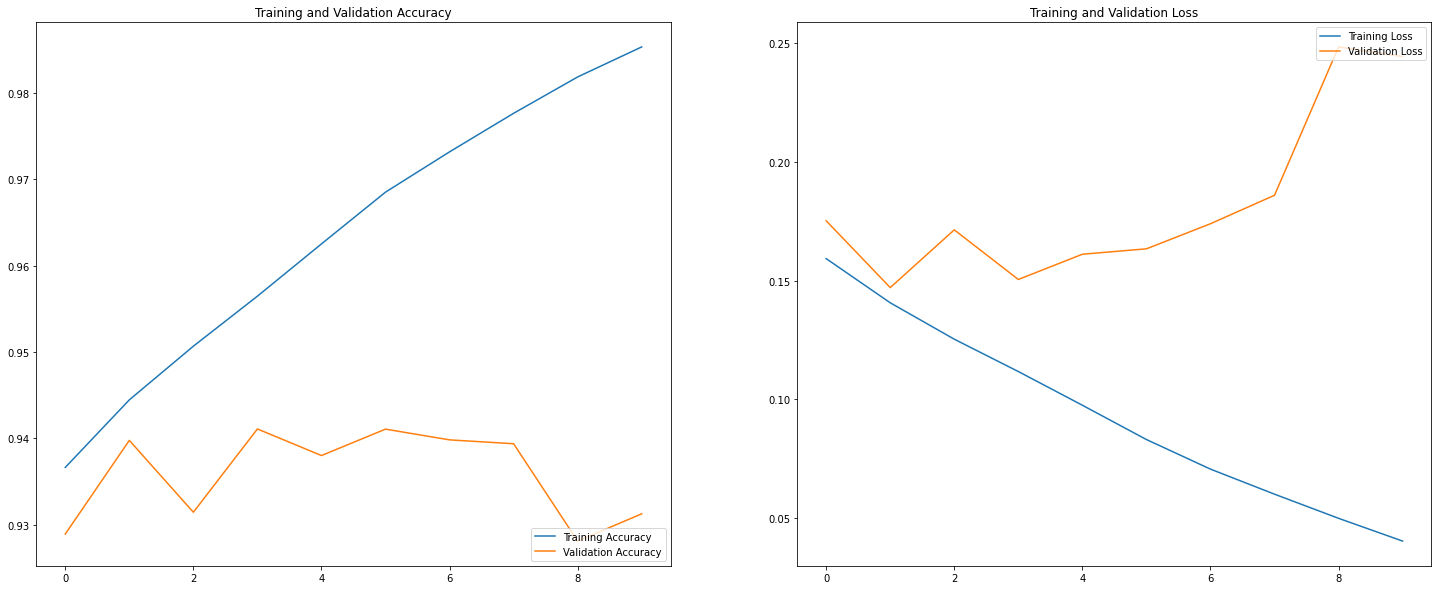

Validation Accuracy 0.8617766911165444


In [0]:
plot_history(model_basic,10)
val_accuracy(model_basic,images_val, val_labels)

This model shows good accuracy with training data, but bad accuracy with validation data, and with training history we can see it kept improving on training data, but strugled with validation data.
The final accuracy on Validation data is 86.17%.
Looking at loss, its similar picture, the traiing loss is declining smoothly over each epoch, but validation loss is increasing which is not a good sign. This model is a good baseline model to begin with and we'll try to improve based on this.

# Deep CNN Model
Now we'll look at our first deep learning model with several layers.
it has 3 pairs of Conv2D and MaxPooling2D layers, then a flatten layer, which is followed by 5 dense layers with dropout layers in between.
This is our first deep CNN.
The loss function and optimzers are same as in the model above.

In [0]:
model_deep = Sequential()
model_deep.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(48,48,3)))
model_deep.add(MaxPooling2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))
model_deep.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model_deep.add(MaxPooling2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))
model_deep.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model_deep.add(MaxPooling2D(pool_size=(2, 2)))
model_deep.add(Dropout(0.25))
model_deep.add(Flatten())
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.5))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.5))
model_deep.add(Dense(64, activation='relu'))
model_deep.add(Dropout(0.5))
model_deep.add(Dense(64, activation='relu'))
model_deep.add(Dropout(0.5))
model_deep.add(Dense(4, activation='sigmoid'))

model_deep.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 44, 44, 16)        1216      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 32)        12832     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 5, 64)         

In [0]:
model_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_deep.fit(images_train, train_labels, epochs=10, validation_data=(images_val, val_labels), batch_size=128)

Train on 98479 samples, validate on 12270 samples
Epoch 1/10
98479/98479 [==============================] - 16s 165us/step - loss: 0.3491 - accuracy: 0.8473 - val_loss: 0.2083 - val_accuracy: 0.9103
Epoch 2/10
98479/98479 [==============================] - 15s 154us/step - loss: 0.2345 - accuracy: 0.9120 - val_loss: 0.1831 - val_accuracy: 0.9303
Epoch 3/10
98479/98479 [==============================] - 15s 154us/step - loss: 0.2094 - accuracy: 0.9231 - val_loss: 0.1669 - val_accuracy: 0.9373
Epoch 4/10
98479/98479 [==============================] - 15s 154us/step - loss: 0.1991 - accuracy: 0.9275 - val_loss: 0.1567 - val_accuracy: 0.9398
Epoch 5/10
98479/98479 [==============================] - 15s 154us/step - loss: 0.1891 - accuracy: 0.9312 - val_loss: 0.1676 - val_accuracy: 0.9365
Epoch 6/10
98479/98479 [==============================] - 15s 154us/step - loss: 0.1847 - accuracy: 0.9328 - val_loss: 0.1444 - val_accuracy: 0.9447
Epoch 7/10
98479/98479 [==============================] 

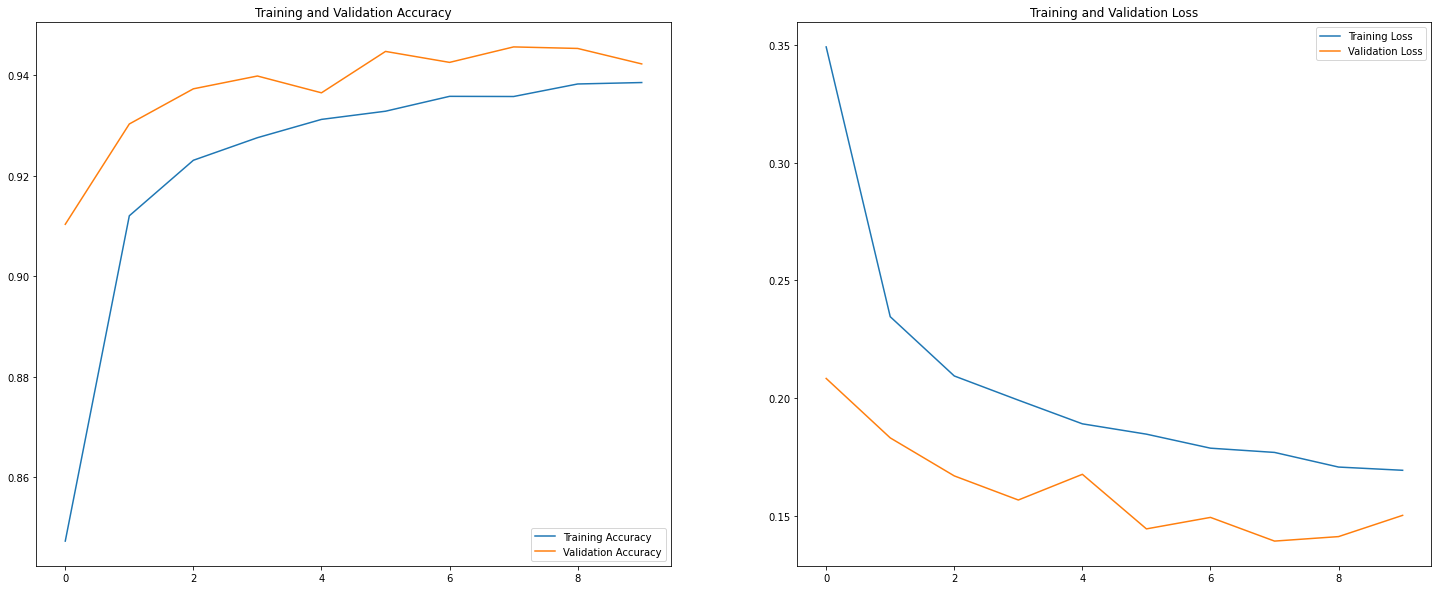

Validation Accuracy 0.8831295843520782


In [0]:
plot_history(model_deep,10)
val_accuracy(model_deep,images_val, val_labels)

This Model gave a validation accruacy of 88.31%, which is not that great from previous model, but looking at its loss and accuracy plots we can see that, accuracy for both training and validation set kep increasing, and the loss kep decreasing. which shows that model is much better than previous on. This was the model used for first submission on Kaggle, but it was trained for around 50 epochs, it gave an accuracy of .91309 on public test dataset. 

After first submission, some tinkering was done with this model by adding few more dense rows, and more pairs of conv2D and maxpooling layers, diff optimizers and loss functions and doing longer training. It did increase the accuracy but not by that much. the final accuracy score with this model on public test data was .91636 .


# Transfer Learning
Next approach to increase overall accuracy was to use transfer learning, by utilizing pre trained models available with keras library. First model used was resnet50. To use any pre trained model, we need to modify the input and output layers according to our dataset. Below code shows how resent50 was used.

# RESENET50
Model was used without including the top, and the input layer was changed to a 48x48x3 size according to our data.
In the output, a flatten layer followed by a dense layer with size 4 and signoid activation function was used.
optimizer used was SGD with a very small learning rate, and a momentum of 0.9.

This model took a very long time to train.

In [0]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(4, activation='sigmoid'))
model_ResNet50V2 = Model(inputs=base_model.input, outputs=add_model(base_model.output))


model_ResNet50V2.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model_ResNet50V2.summary()

model_ResNet50V2.fit(images_train, train_labels, epochs=10, validation_data=(images_val, val_labels), batch_size=128)

94674944/94668760 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 26, 26, 64)   0           conv1_conv[0][0]                 
___________________________

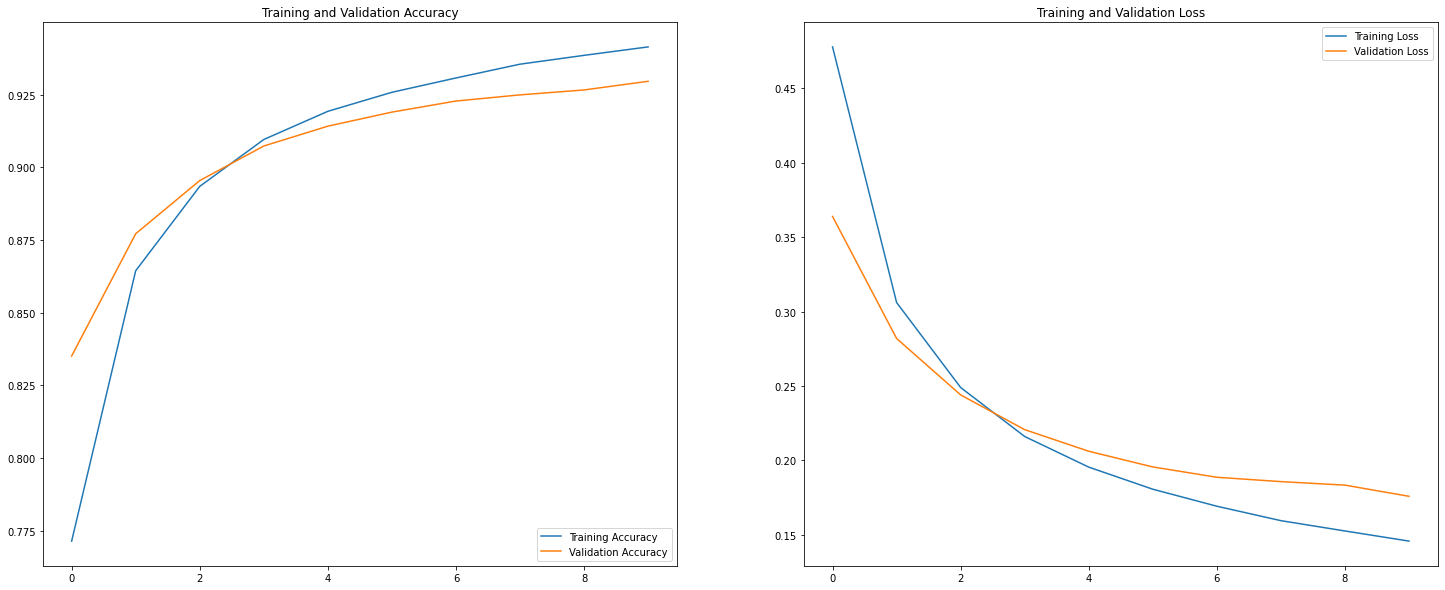

Validation Accuracy 0.8605541972290138


In [0]:
plot_history(model_ResNet50V2,10)
val_accuracy(model_ResNet50V2,images_val, val_labels)

This model took a very long time in training, and the perfromance in the end was similar to our first basic model with around 86.05% on validation data set. the increase in accuracy was very smooth, and decrease in loss was also very smooth.
This model was not used on Public Test becuase the accuracy was similar to our first model.

# VGG16
Next model used vgg16 and to improve its perfromance data augmentation was added and a learning rate scheduler was added, which gradullay decreased the learning rate.

In data augmentation, rotations, width shift, height shift, horizontal flip were used.

Learning rate schedule started to decease learning rate after 10th epoch.

In [0]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(4, activation='sigmoid'))
modelVGG_raw = Model(inputs=base_model.input, outputs=add_model(base_model.output))


modelVGG_raw.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

modelVGG_raw.summary()

batch_size = 128
epochs = 10 #50

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(images_train)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = modelVGG_raw.fit_generator(
    train_datagen.flow(images_train, train_labels, batch_size=batch_size),
    steps_per_epoch=images_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(images_val, val_labels),
    callbacks=[callback]
)

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
____________________________________________________________

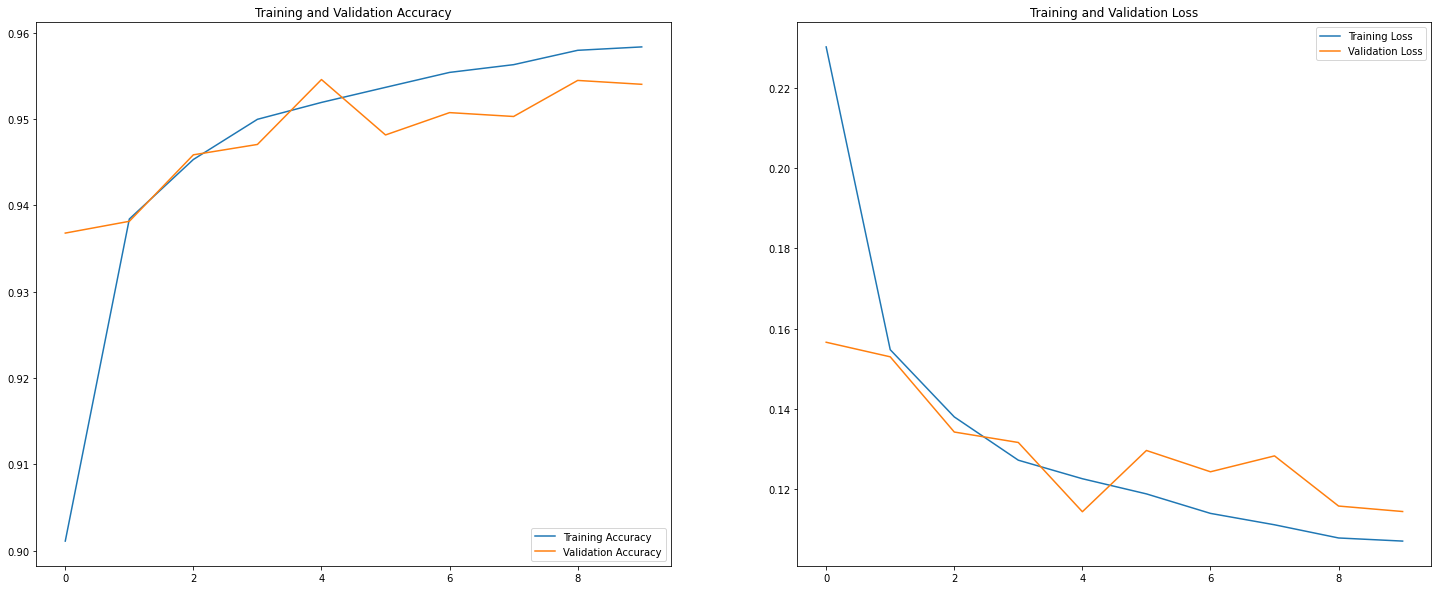

Validation Accuracy 0.9075794621026895


In [0]:
plot_history(modelVGG_raw,epochs)
val_accuracy(modelVGG_raw,images_val, val_labels)

In [0]:
# modelVGG_raw.save('/content/gdrive/My Drive/CelebA/vgg_raw')
modelVGG_raw = load_model('/content/drive/My Drive/CelebA/vgg_raw')
val_accuracy(modelVGG_raw,images_val, val_labels)

Validation Accuracy 0.9250203748981255


This was one of the better models, and it gave a much better accuracy in validation data set of about 92.50%. In history plots above its only showing 10 epchs, just for display purposes, but actually it was trained for 50 epochs with learning rate schedule that started to decrease learning rate in each epoch after the 10th epoc, the model was trained and saved for future use. This model was used on public data set on kaggle and it gave accuracy of 0.92752 on public test data set which is consistent with what we got on our validation set. This is till now our best model. We can see that after training it for 50 epochs, our validation accuracy increased from .9075 to .9250 which shows that our leraning rate scheduler did help in increased accuracy.

# VGG16 with frozen layers

Next step was to try and see perfromance of same model by freezing all layers of VGG16 except the last 5 layers and see if that increases or decreases the perfromance, even though the imagenet data set is based on image classfication of 1000 classes, its doesn't hurt to see perfromance of network with frozen rows.

In [0]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(4, activation='sigmoid'))
modelVGG_frozen = Model(inputs=base_model.input, outputs=add_model(base_model.output))

for layer in modelVGG_frozen.layers[:-5]:
    layer.trainable = False

modelVGG_frozen.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

modelVGG_frozen.summary()

batch_size = 32
epochs = 10 #50


train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(images_train)

def scheduler(epoch):
  if epoch < 5:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = modelVGG_frozen.fit_generator(
    train_datagen.flow(images_train, train_labels, batch_size=batch_size),
    steps_per_epoch=images_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(images_val, val_labels),
    callbacks=[callback]
)
#modelVGG.save('/content/gdrive/My Drive/CelebA/vgg_frozen')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

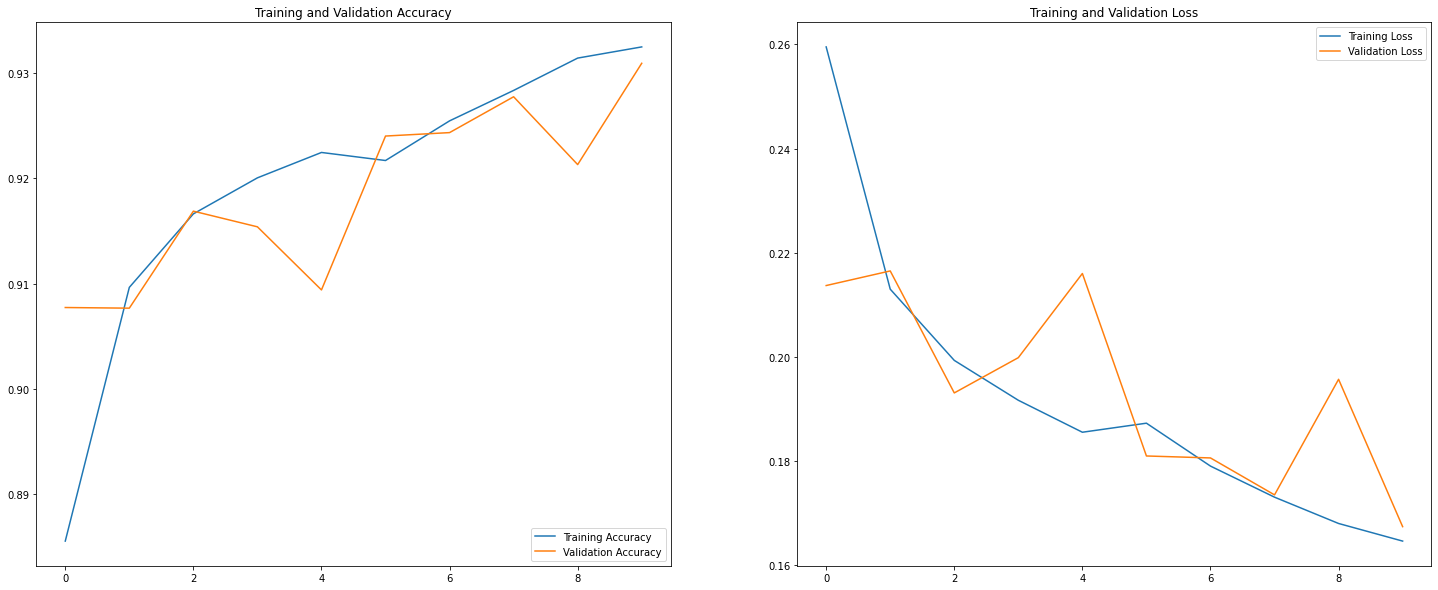

Validation Accuracy 0.9075794621026895


In [0]:
plot_history(modelVGG_frozen,epochs)
val_accuracy(modelVGG_raw,images_val, val_labels)

In [0]:
modelVGG_frozen = load_model('/content/drive/My Drive/CelebA/vgg_frozen')
val_accuracy(modelVGG_frozen,images_val, val_labels)

Validation Accuracy 0.9192339038304809


Originally this model was trained for 50 epochs and saved, the history above is for 10 epochs. This model didn;t perfrom better by freezing the layers, the same model with all layers trainable perfromed better thant this.

# VGG16 with Additional Layers
Now trying the same model with few additonal dense and dropout layers at end.

In [0]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(64, activation="relu"))
add_model.add(Dropout(0.5))
add_model.add(Dense(4, activation='sigmoid'))
   
modelVGG_raw_AL = Model(inputs=base_model.input, outputs=add_model(base_model.output))


modelVGG_raw_AL.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

modelVGG_raw_AL.summary()

batch_size = 32
epochs = 15

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(images_train)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = modelVGG_raw_AL.fit_generator(
    train_datagen.flow(images_train, train_labels, batch_size=batch_size),
    steps_per_epoch=images_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(images_val, val_labels),
    callbacks=[callback]
)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

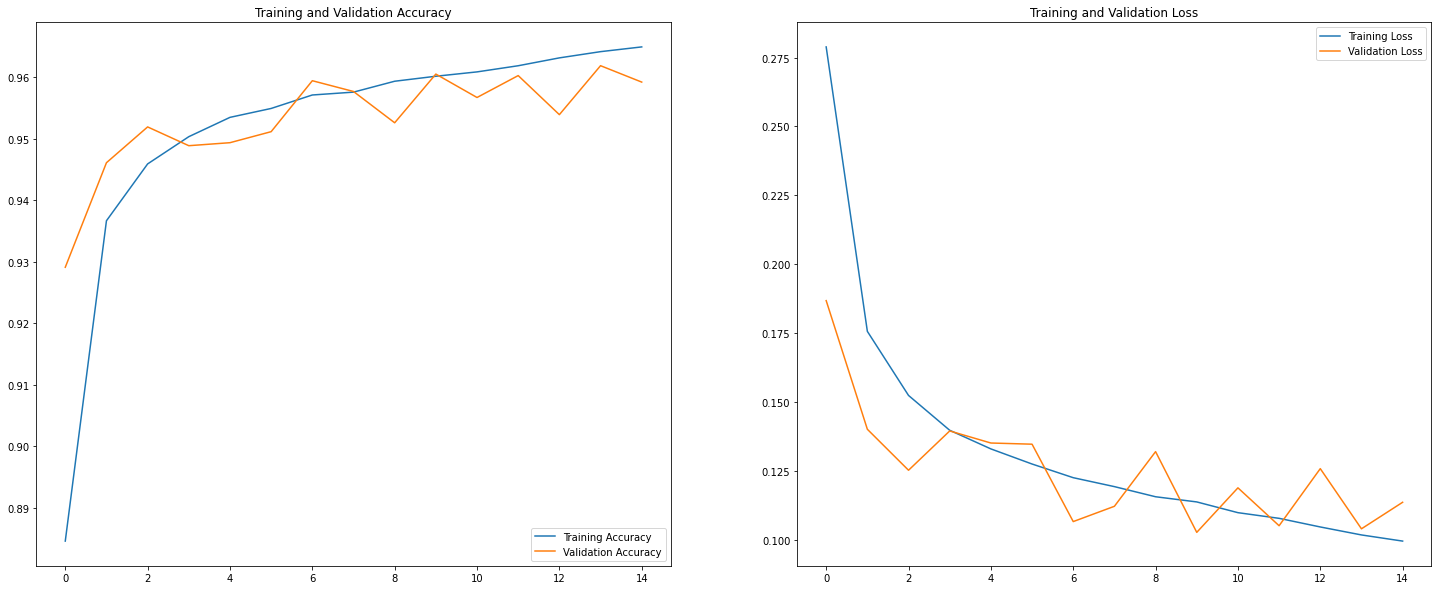

Validation Accuracy 0.9188264058679707


In [0]:
plot_history(modelVGG_raw_AL,epochs)
val_accuracy(modelVGG_raw_AL,images_val, val_labels)

In [0]:
modelVGG_AL = load_model('/content/drive/My Drive/CelebA/vgg_raw_mod')
val_accuracy(modelVGG_AL,images_val, val_labels)

Validation Accuracy 0.9205378973105135


This model was originally trained with 50 epochs and gave good accuracy but adding additonal layer didn;t improve it from the same model without these additonal layers. The accuracy here was .9205

# Ensemble Learning
Next step to improve perfromance was to use ensemble learning on the best 3 models above. Ensemble models in machine learning combine the decisions from multiple models to improve the overall performance. We will use the 3 best models above and combine there results


2 ensemble methods were used, in one mode of predicton from each model were taken and the result was used as predictions.

In second methods, predciton probabilities were summed and the max probability was used as prediction.

In [0]:
pred1_all = np.argmax(modelVGG_AL.predict(images_val), axis=-1)
pred2_all = np.argmax(modelVGG_frozen.predict(images_val), axis=-1)
pred3_all = np.argmax(modelVGG_raw.predict(images_val), axis=-1)

final_pred = np.array([])
for i in range(0,len(images_val)):
    final_pred = np.append(final_pred, stats.mode([pred1_all[i], pred2_all[i], pred3_all[i]] )[0] )

print('Validation Accuracy',accuracy_score(labels_val , final_pred))

Validation Accuracy 0.9154034229828851


In [0]:
models = [modelVGG_AL, modelVGG_frozen, modelVGG_raw]

def ensemble_predictions(members, testX):
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  # sum across ensemble members
  summed = np.sum(yhats, axis=0)
  # argmax across classes
  result = np.argmax(summed, axis=1)
  return result



In [0]:
class_index = ensemble_predictions(models, images_val)
print('Validation Accuracy Default',accuracy_score(labels_val , class_index))


Validation Accuracy Default 0.9185004074979625


In [0]:
pred_public = ensemble_predictions(models, images_test_public)
df = pd.DataFrame(
  {'ID': files_test_public,
    'Prediction': pred_public
  })
df[['Prediction']] = df[['Prediction']].astype(int)
df.to_csv('RESULTS.csv', index=False)
files.download("RESULTS.csv")

First ensemble methods gave an accuracy of .9154 and second gave .9185 on validation data set. The second one was the best accuracy we have got uptill now.
This ensemble model was used in kaggle public test data and gave an accuracy of 0.93935, which gave me the first rank in kaggle public test leaderboard.


When private data set was released, it was seen that many people who had high rank in public dataset now had a only around 60% accuracy on private dataset, which made me think that there is something important that I did not anticipate.
First thing that came to mind was that maybe the train val split that was given by default was low accuracy for some target classes and as I had investigated earlier that train and test data set did not have a balanced number of target classes, so my next step was to train all 3 models above on balanced split of dataset and see if it makes any difference.

# Balanced DataSet

# VGG16 Frozen Layers With Balanced Data Split

In [0]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(4, activation='sigmoid'))
modelVGG_frozen_balanced = Model(inputs=base_model.input, outputs=add_model(base_model.output))

for layer in modelVGG_frozen_balanced.layers[:-5]:
    layer.trainable = False

modelVGG_frozen_balanced.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

modelVGG_frozen_balanced.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [0]:
batch_size = 32
epochs = 15


train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

def scheduler(epoch):
  if epoch < 5:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


history = modelVGG_frozen_balanced.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=images_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)

Epoch 1/15
3077/3077 [==============================] - 81s 26ms/step - loss: 0.2591 - accuracy: 0.8859 - val_loss: 0.2058 - val_accuracy: 0.9123
Epoch 2/15
3077/3077 [==============================] - 74s 24ms/step - loss: 0.2119 - accuracy: 0.9096 - val_loss: 0.2042 - val_accuracy: 0.9131
Epoch 3/15
3077/3077 [==============================] - 74s 24ms/step - loss: 0.1978 - accuracy: 0.9169 - val_loss: 0.1811 - val_accuracy: 0.9241
Epoch 4/15
3077/3077 [==============================] - 74s 24ms/step - loss: 0.1901 - accuracy: 0.9205 - val_loss: 0.1770 - val_accuracy: 0.9268
Epoch 5/15
3077/3077 [==============================] - 74s 24ms/step - loss: 0.1827 - accuracy: 0.9242 - val_loss: 0.1878 - val_accuracy: 0.9211
Epoch 6/15
3077/3077 [==============================] - 74s 24ms/step - loss: 0.1827 - accuracy: 0.9239 - val_loss: 0.1755 - val_accuracy: 0.9269
Epoch 7/15
3077/3077 [==============================] - 74s 24ms/step - loss: 0.1757 - accuracy: 0.9269 - val_loss: 0.1695 -

Plot Hisotry

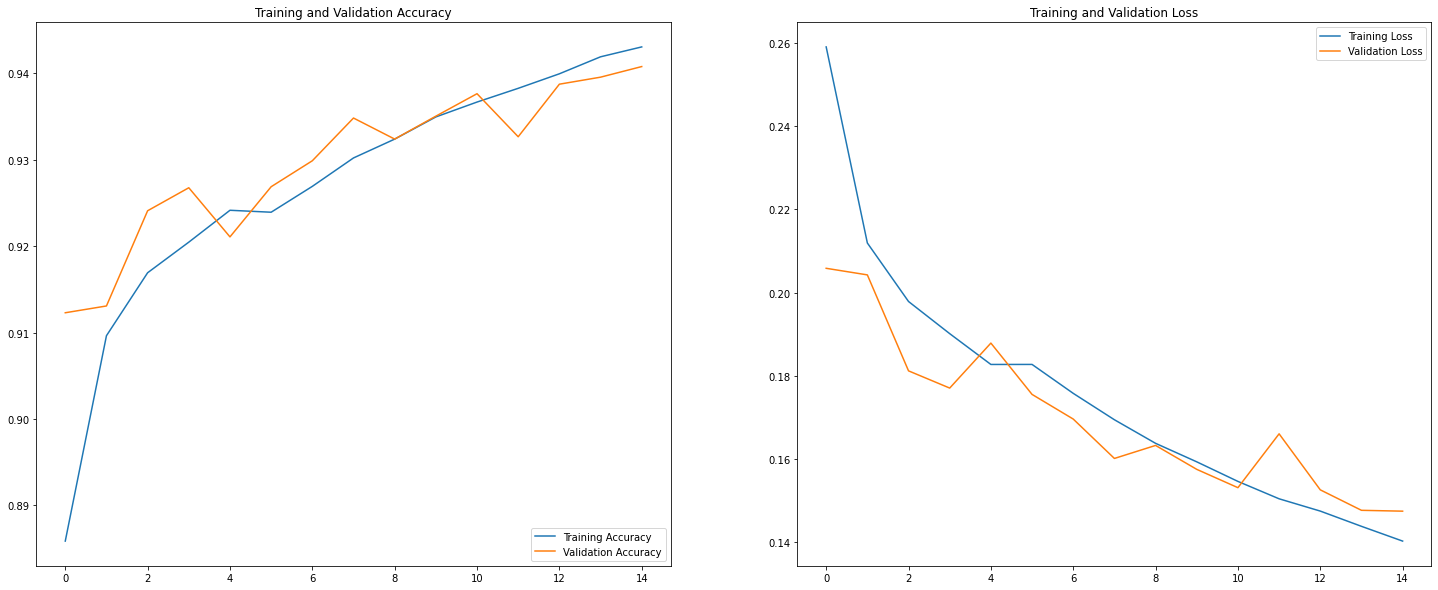

In [0]:
plot_history(modelVGG_frozen_balanced,epochs)

In [0]:
val_accuracy(modelVGG_frozen_balanced,X_test, val_labels)

Validation Accuracy 0.8883190059958102


This model did not perfrom good with the balanced data set and gave an accuracy of .8883 which is much lower than what we got from our best model so far. 

# VGG16 Model without Freezing Row and Balanced Data Set


In [0]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(4, activation='sigmoid'))
modelVGG_raw_baln = Model(inputs=base_model.input, outputs=add_model(base_model.output))


modelVGG_raw_baln.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

modelVGG_raw_baln.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [0]:
batch_size = 128
epochs = 15

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

def scheduler(epoch):
  if epoch < 5:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = modelVGG_raw_baln.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)
# modelVGG_raw_baln.save('/content/gdrive/My Drive/CelebA/vgg_raw_balanced')

Epoch 1/15
648/648 [==============================] - 63s 97ms/step - loss: 0.2377 - accuracy: 0.8974 - val_loss: 0.1719 - val_accuracy: 0.9312
Epoch 2/15
648/648 [==============================] - 55s 86ms/step - loss: 0.1611 - accuracy: 0.9349 - val_loss: 0.1410 - val_accuracy: 0.9443
Epoch 3/15
648/648 [==============================] - 55s 85ms/step - loss: 0.1430 - accuracy: 0.9424 - val_loss: 0.1259 - val_accuracy: 0.9510
Epoch 4/15
648/648 [==============================] - 55s 86ms/step - loss: 0.1325 - accuracy: 0.9472 - val_loss: 0.1217 - val_accuracy: 0.9521
Epoch 5/15
648/648 [==============================] - 55s 85ms/step - loss: 0.1262 - accuracy: 0.9504 - val_loss: 0.1141 - val_accuracy: 0.9558
Epoch 6/15
648/648 [==============================] - 55s 86ms/step - loss: 0.1247 - accuracy: 0.9509 - val_loss: 0.1292 - val_accuracy: 0.9487
Epoch 7/15
648/648 [==============================] - 55s 85ms/step - loss: 0.1166 - accuracy: 0.9547 - val_loss: 0.1067 - val_accuracy:

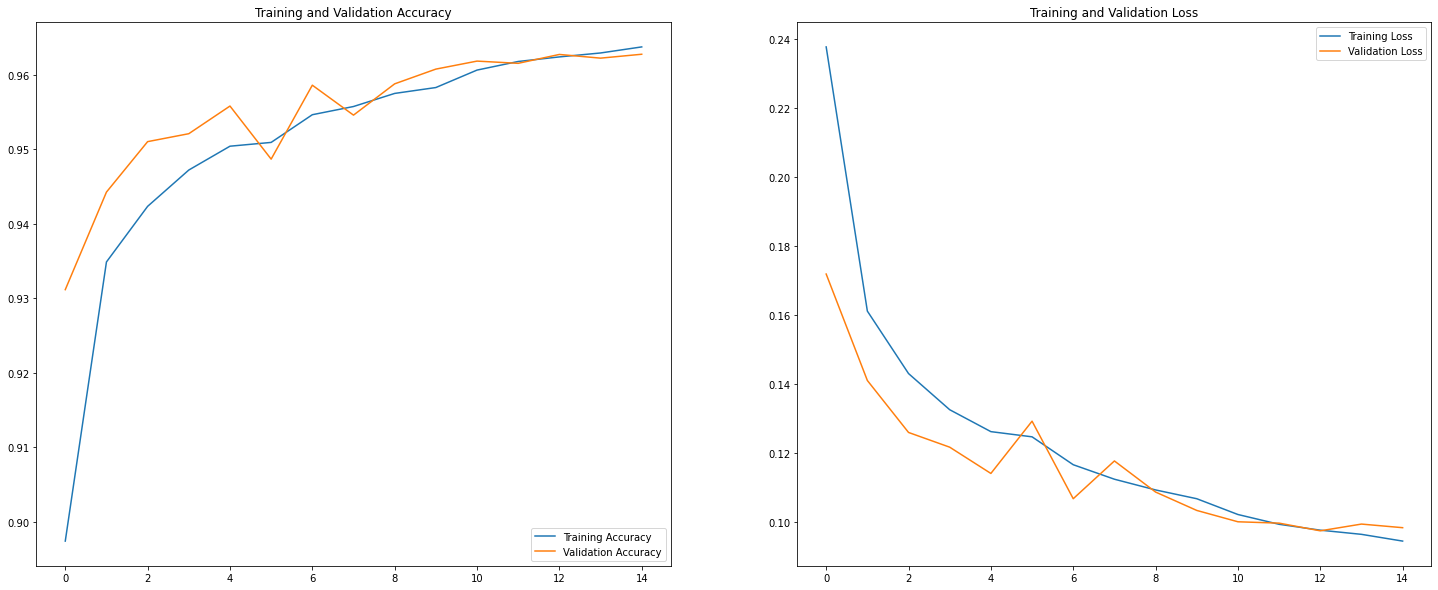

Validation Accuracy 0.9262804305425124


In [0]:
plot_history(modelVGG_raw_baln,epochs)

pred_val = np.argmax(modelVGG_raw_baln.predict(X_test), axis=-1)
print('Validation Accuracy',accuracy_score(np.argmax(y_test, axis=1) , pred_val))

This model without any frozen layers with our balanced data set gave a very good result on validation data set, compared to default split which has an accuracy of 0.9250 this has a very similar but better accuracy of 0.9262 which tells that the split has no signifcant difference on our validation set.

# VGG16 with additonal layers, no frozen rows and Balanced Dataset

In [0]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(64, activation="relu"))
add_model.add(Dropout(0.5))
add_model.add(Dense(4, activation='sigmoid'))
   
modelVGG_raw_AL_bal = Model(inputs=base_model.input, outputs=add_model(base_model.output))


modelVGG_raw_AL_bal.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

modelVGG_raw_AL_bal.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [0]:
batch_size = 32
epochs = 15

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = modelVGG_raw_AL_bal.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)

modelVGG_raw_AL_bal.save('/content/gdrive/My Drive/CelebA/modelVGG_raw_mod_bal')

Epoch 1/15
2595/2595 [==============================] - 79s 31ms/step - loss: 0.2945 - accuracy: 0.8755 - val_loss: 0.1600 - val_accuracy: 0.9385
Epoch 2/15
2595/2595 [==============================] - 72s 28ms/step - loss: 0.1821 - accuracy: 0.9339 - val_loss: 0.1493 - val_accuracy: 0.9409
Epoch 3/15
2595/2595 [==============================] - 72s 28ms/step - loss: 0.1580 - accuracy: 0.9430 - val_loss: 0.1196 - val_accuracy: 0.9559
Epoch 4/15
2595/2595 [==============================] - 72s 28ms/step - loss: 0.1444 - accuracy: 0.9492 - val_loss: 0.1088 - val_accuracy: 0.9575
Epoch 5/15
2595/2595 [==============================] - 72s 28ms/step - loss: 0.1372 - accuracy: 0.9514 - val_loss: 0.1082 - val_accuracy: 0.9588
Epoch 6/15
2595/2595 [==============================] - 72s 28ms/step - loss: 0.1303 - accuracy: 0.9535 - val_loss: 0.1169 - val_accuracy: 0.9558
Epoch 7/15
2595/2595 [==============================] - 72s 28ms/step - loss: 0.1249 - accuracy: 0.9555 - val_loss: 0.1091 -

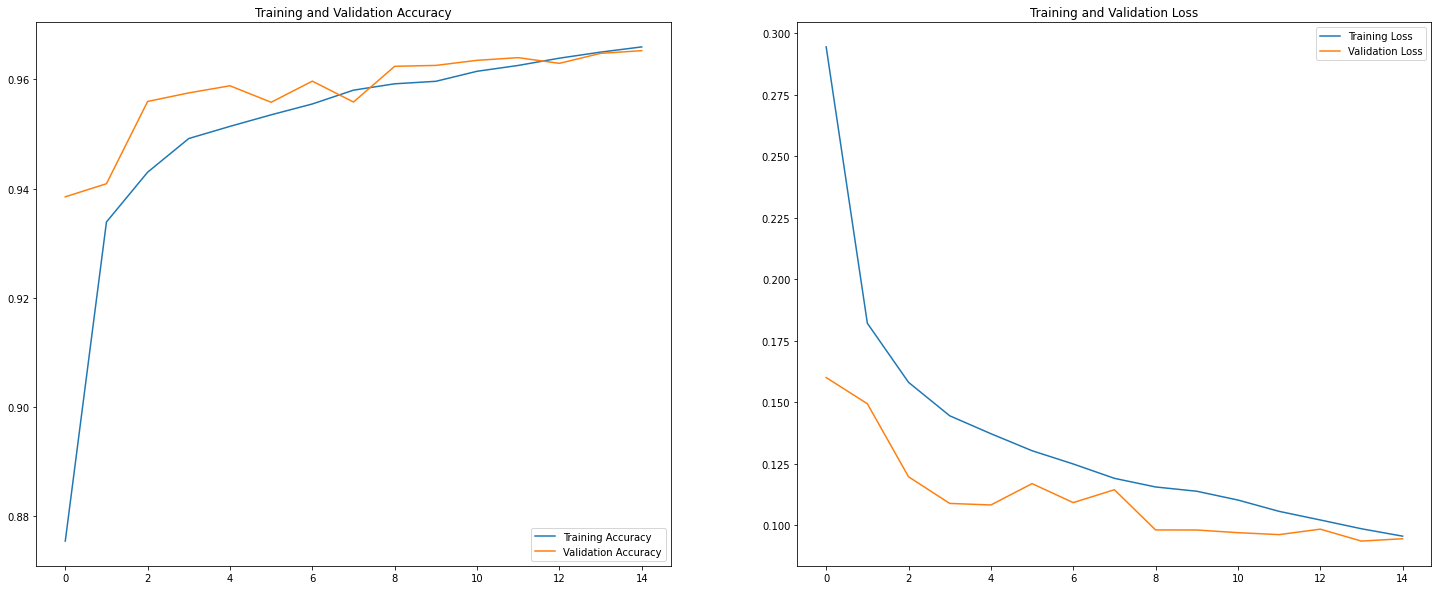

Validation Accuracy 0.9306869898143466


In [0]:
plot_history(modelVGG_raw_AL_bal,epochs)

pred_val = np.argmax(modelVGG_raw_AL_bal.predict(X_test), axis=-1)
print('Validation Accuracy',accuracy_score(np.argmax(y_test, axis=1) , pred_val))

This model similar to what we did above but with balanced data set gave us better accuracy of .9306 compared to same model with default split which had an accuracy of 0.9205 . By doing a balanced split we are getting some improvement in our accuracy.

# Final Ensemble Model
Now we have 6 models ready, and its time to do predictions on our private test data, and its a tough choice to see what combination of these models will perfrom better. we'll do some tests to see what combination is better and use the best ones for our private test.

After training all models were saved so they can be used later, so we will load all of them from google drive and compare results.


In [0]:
model1 = load_model('/content/drive/My Drive/CelebA/vgg_frozen')
model2 = load_model('/content/drive/My Drive/CelebA/vgg_frozen_balanced_data')
model3 = load_model('/content/drive/My Drive/CelebA/vgg_raw_mod')
model4 = load_model('/content/drive/My Drive/CelebA/modelVGG_raw_mod_bal')
model5 = load_model('/content/drive/My Drive/CelebA/vgg_raw')
model6 = load_model('/content/drive/My Drive/CelebA/vgg_raw_balanced')

In [0]:
models = [model1]

Accuracy of each model was checked on the validation set which we had by default, and the balanced validation set.

In [0]:
for m in models:
  pred_val = np.argmax(m.predict(X_test), axis=-1)
  print('Validation Accuracy on Balanced Split',accuracy_score(np.argmax(y_test, axis=1) , pred_val))

for m in models:
  pred_val = np.argmax(m.predict(images_val), axis=-1)
  print('Validation Accuracy Default Split',accuracy_score(labels_val , pred_val))


Validation Accuracy on Balanced Split 0.9568373907390016
Validation Accuracy on Balanced Split 0.8883190059958102
Validation Accuracy on Balanced Split 0.9390305569601964
Validation Accuracy on Balanced Split 0.9346239976883624
Validation Accuracy on Balanced Split 0.9423896554215127
Validation Accuracy on Balanced Split 0.9291699776060103
Validation Accuracy Default Split 0.9192339038304809
Validation Accuracy Default Split 0.8858190709046455
Validation Accuracy Default Split 0.9205378973105135
Validation Accuracy Default Split 0.9296658516707417
Validation Accuracy Default Split 0.9250203748981255
Validation Accuracy Default Split 0.919559902200489


Accuracy with all 6 models used with second ensemble method.

In [0]:
class_index_d = ensemble_predictions(models, images_val)
print('Validation Accuracy Default',accuracy_score(labels_val , class_index_d))


Validation Accuracy Default 0.9297473512632437


In [0]:
class_index_b = ensemble_predictions(models, X_test)
print('Validation Accuracy Default',accuracy_score(np.argmax(y_test, axis=1) , class_index_b))

Validation Accuracy Default 0.9568373907390016


In [0]:
private_test_labels = ensemble_predictions(models, images_test_private)


df = pd.DataFrame(
    {'ID': files_test_private,
     'Prediction': private_test_labels
    })

df[['Prediction']] = df[['Prediction']].astype(int)
df.dtypes
df.to_csv('45565694_deep_learning.csv', index=False)
files.download("45565694_deep_learning.csv")

The combination of these 6 models gave a good result on our balanced dataset and lower result on the validation set, I decided to use this combination of 6 models for private data set, but unfortunately it gave an accuracy of only 0.62823 .


# Conclusion

After this result, I decided to look at some of the images from private test data, and found almost all images were augmented, they were rotated and/or flipped. and they had a black baground after rotation. Whereas the Data augmentation done by model above, didn't include a black background when titlted, which made it hard for the model to predict the correct hair colour, and without looking at wrongly predicted images in private dataset it seems most would have been labelled as black hair colour due to the black background.
To make this model better, the data augmentation should've been done that is similar to images in private data set, which would decrease accuracy in public test data, but would give better results in private test data.

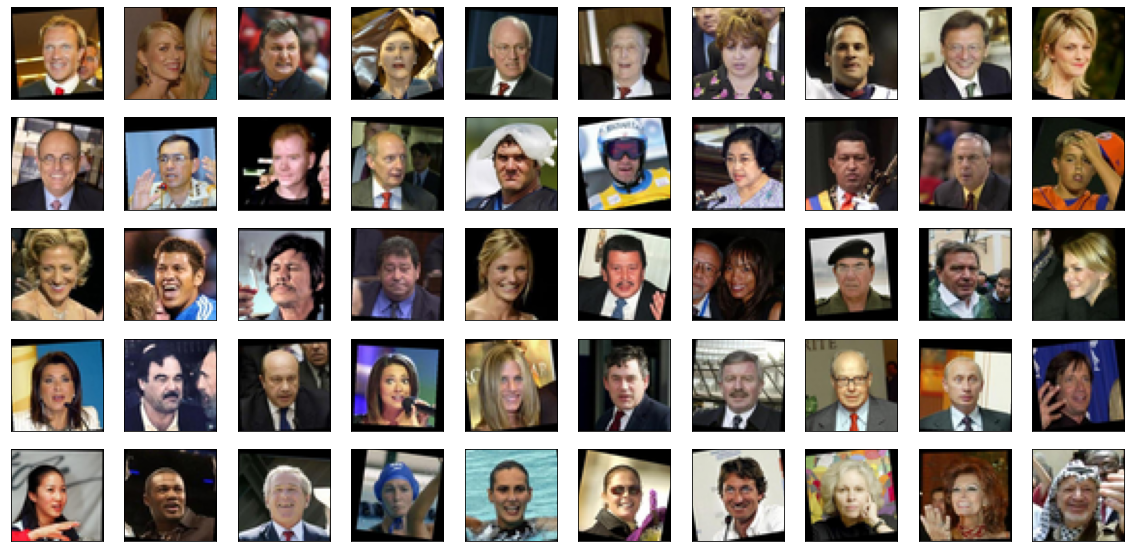

In [0]:
plt.figure(figsize=(20,20))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    num = randint(0,len(images_test_private))
    plt.imshow(images_test_private[num], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

I decided to see if my augmention created similar images.

In [0]:
it = train_datagen.flow(images_train[:25], labels_train[:25], batch_size=32)
x_batch, y_batch = next(it)

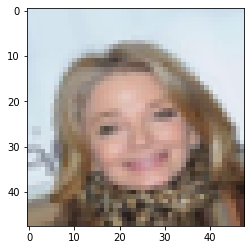

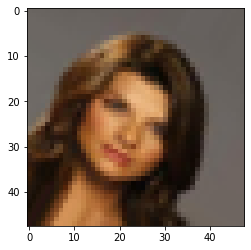

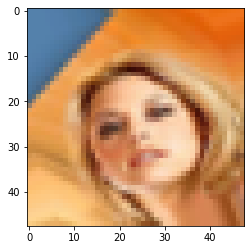

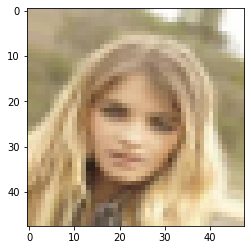

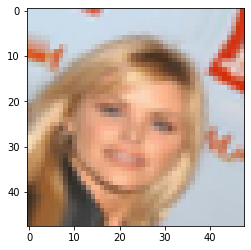

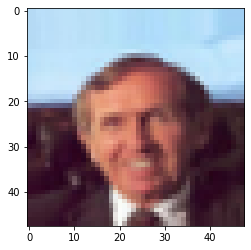

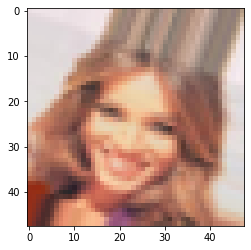

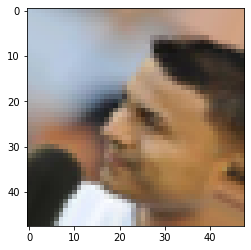

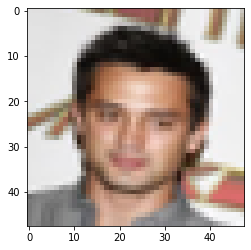

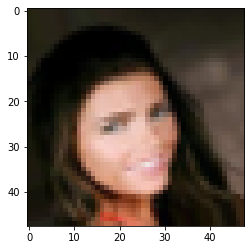

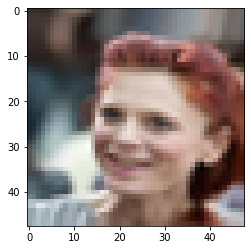

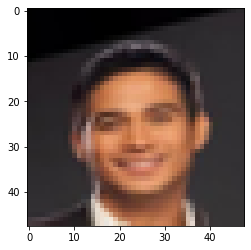

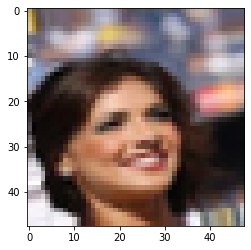

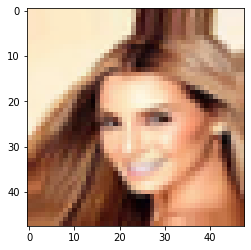

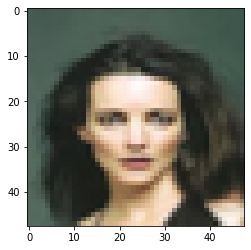

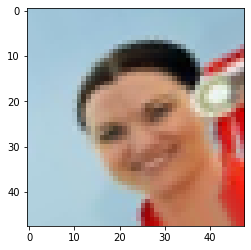

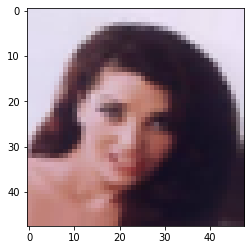

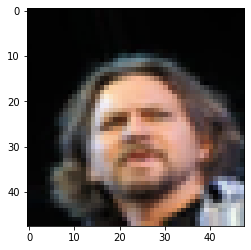

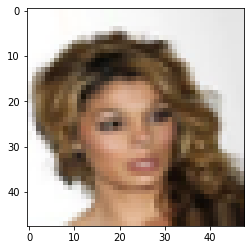

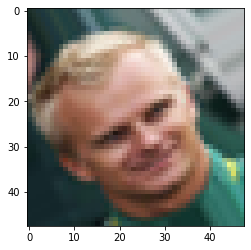

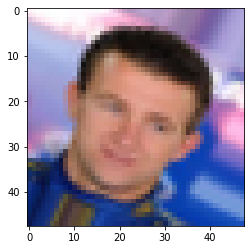

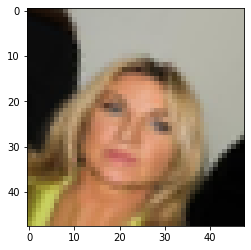

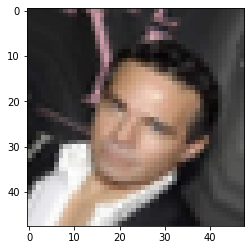

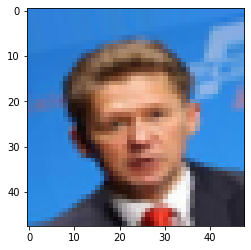

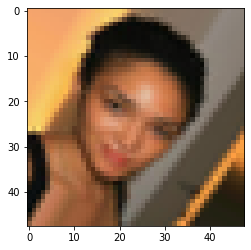

IndexError: ignored

In [0]:
for i in range (0,48):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()